# Segmentation Algorithm Demo for Golgi

Should we have a little description of DSP here?

Also, we may add a picture of the corresponding row in the lookup table for readers to correlate this notebook with a specifc row in the lookup table.


----------------------------------------
PLACEHOLDER: description of the functions to be used, and the usage of each parameters

----------------------------------------


In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage, omeTifWriter                            

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d  
from aicssegmentation.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation   # function for post-processing (size filter)
from aicssegmentation.core.visual import explore_dot_3d
from aicssegmentation.core.utils import morphology_preserving_thinning

from skimage.measure import label
from skimage.filters import threshold_triangle, threshold_otsu


ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/


## Loading the data

In [2]:
FILE_NAME = '/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/ST6GAL1/original/3500001289_100X_20170915_25_44_1-Scene-11-P39-E08.czi'
#FILE_NAME = '/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/ST6GAL1/original/3500001289_100X_20170915_25_44_1r-Scene-10-P29-E07.czi'
#FILE_NAME = '/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/ST6GAL1/original/3500001232_100X_20170825_3-Scene-18-P53-F05.czi'

reader = AICSImage(FILE_NAME) 
IMG = reader.data

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 65, 624, 924)


## Preview of the image

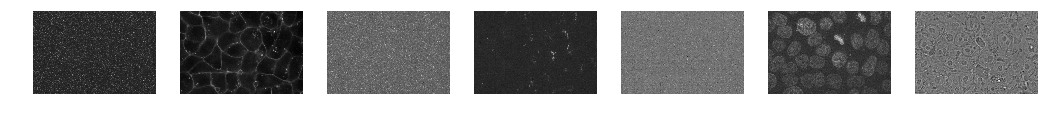

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
for channel in range(N_CHANNELS):
    ax[channel].axis('off')
    ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

## Image segmentation

### Step 1: Pre-Processing

In [3]:
################################
## PARAMETERS for this step ##
structure_channel = 3
intensity_scaling_param = [9, 19]
gaussian_smoothing_sigma = 1
################################

structure_img0 = IMG[0,structure_channel,:,:,:]

# intensity normalization
structure_img = intensity_normalization(structure_img0, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_3d(structure_img, sigma=gaussian_smoothing_sigma)

intensity normalization: normalize into [mean - 9 x std, mean + 19 x std] 
intensity normalization completes


In [42]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f410dd780…

#### If the contrast looks too off, you can play with the normalization parameters

In [5]:
from aicssegmentation.pre_processing_utils import suggest_normalization_param

In [6]:
suggest_normalization_param(structure_img0)

405.0569446579062
9.783182506889437
588.0
316
592
suggested lower range is 19.0, which is 590.9374122888055
suggested upper range is 9.0, which is 317.00830209590123
So, suggested parameter for normalization is [9.0, 19.0]
You may also increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions) to further enhance the contrast


### Step 2: Core Algorithm

#### step 2.1: Cell-wise local adaptive threshold 

In [4]:
th_low_level = threshold_triangle(structure_img_smooth)
bw_low_level = structure_img_smooth > th_low_level
bw_low_level = remove_small_objects(bw_low_level, min_size=1200, connectivity=1, in_place=True)
bw_low_level = dilation(bw_low_level, selem=ball(3))

In [85]:
view(segmentation_quick_view(bw_low_level))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f410dd7…

In [6]:
lab_low, num_obj = label(bw_low_level, return_num=True, connectivity=1)
view(lab_low.astype(np.uint8))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f9fc490…

In [7]:
idx=23
bw_high_level = np.zeros_like(bw_low_level)
single_obj = lab_low==(idx+1)
local_otsu = threshold_otsu(structure_img_smooth[single_obj>0])
bw_high_level[np.logical_and(structure_img_smooth>local_otsu*0.95, single_obj)]=1
view(segmentation_quick_view(bw_high_level))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f9fc490…

In [12]:
nb = morphology_preserving_thinning(bw_high_level, 1.6, 1)
nb2 = morphology_preserving_thinning(bw_high_level, 3, 2)

In [11]:
view(segmentation_quick_view(nb))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fa07c2b…

In [13]:
view(segmentation_quick_view(nb2))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fa07c2b…

In [5]:
bw_high_level = np.zeros_like(bw_low_level)
lab_low, num_obj = label(bw_low_level, return_num=True, connectivity=1)
for idx in range(num_obj):
    single_obj = lab_low==(idx+1)
    local_otsu = threshold_otsu(structure_img_smooth[single_obj>0])
    bw_high_level[np.logical_and(structure_img_smooth>local_otsu*0.95, single_obj)]=1

In [6]:
view(segmentation_quick_view(bw_high_level))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fdb5da6…

In [9]:
nb = morphology_preserving_thinning(bw_high_level, 1.6, 1)

In [14]:
from skimage.morphology import medial_axis
from scipy.ndimage import distance_transform_edt
from skimage.morphology import erosion, ball

In [15]:
bw = bw_high_level>0
min_thickness=1.6
thin=1
safe_zone = np.zeros_like(bw)
for zz in range(bw.shape[0]):
    if np.any(bw[zz, :, :]):
        ctl = medial_axis(bw[zz, :, :] > 0)
        dist = distance_transform_edt(ctl == 0)
        safe_zone[zz, :, :] = dist > min_thickness + 1e-5
rm_candidate = np.logical_xor(bw > 0, erosion(bw > 0, ball(thin)))

In [17]:
rm = np.logical_and(safe_zone, rm_candidate)

In [19]:
bw_high_level[rm>0]=0

In [20]:
SEG= bw_high_level>0
out=SEG.astype(np.uint8)
out[out>0]=255
writer = omeTifWriter.OmeTifWriter('/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/figure_source/after_thin.ome.tif')
writer.save(out)

In [18]:
view(segmentation_quick_view(rm))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fa4716b…

In [11]:
view(segmentation_quick_view(bw_high_level))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fa4716b…

#### step 2.2: laplacian of gaussian filter 

In [7]:
################################
## PARAMETERS for this step ##
dot_3d_sigma = 1.6
dot_3d_cutoff = 0.02
################################

response = dot_3d(structure_img_smooth, log_sigma=dot_3d_sigma)
bw_extra = response > dot_3d_cutoff

In [10]:
view(segmentation_quick_view(response > 0.02))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7fdb5da6…

In [62]:
view(segmentation_quick_view(bw_extra))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f410dd7…

#### step 2.3: combine the two parts

In [18]:
bw = np.logical_or(bw_high_level, bw_extra)

In [19]:
# Find a region of interest (ROI) in segmentation image above, and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [362, 58, 631, 382]
view(seg_fluo_side_by_side(structure_img,bw,roi=ROI))

# or comment out the following line to see the whole FOV
#view(seg_fluo_side_by_side(structure_img,seg))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f3b940d8b…

#### If the segmentation is satisfactory (note: step 2.2 can further cut touching spots), go to Step 2. directly; otherwise, there are two parameters you can tune to improve the performance. Follow the steps below:

--------------------------
Placeholder:  Describe the effect of each parameter

------------------------------

In [20]:
# find a small region of interest, 
# type in below the coordinates of upper left corner and lower right corner of the ROI
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [362, 58, 631, 382]
view(explore_dot_3d(structure_img_smooth, sigma=4, th=0.04, roi=ROI))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f02b288be…

#### Now, if you have found a satisfatory set of parameters, type in the parameters below and re-run the segmentation. Then, move to step 3

In [15]:
# type in parameters here:
dot_3d_sigma = 1
dot_3d_cutoff = 0.012

response = dot_3d(structure_img_smooth, log_sigma=dot_3d_sigma)
bw = response > dot_3d_cutoff

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [9]:
local_maxi = peak_local_max(structure_img,labels=label(remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)), min_distance=2, indices=False)
distance = distance_transform_edt(bw)
seg = watershed(-distance, label(dilation(local_maxi,selem=ball(1))), mask=bw, watershed_line=True)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Step 3: Post-Processing 

In [60]:
################################
## PARAMETERS for this step ##
minArea = 10
################################

final_seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [17]:
view(seg_fluo_side_by_side(structure_img,SEG))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f2b44072c…

### You can also focus your inspection on a small ROI

In [ ]:
# Find ROI in segmentation image above (not the raw image on the right part), and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [244, 361, 441, 562]
view(seg_fluo_side_by_side(structure_img,SEG, roi=ROI))

### You may also physically save the segmentation results into a ome.tif file

In [82]:
SEG= final_seg>0
out=SEG.astype(np.uint8)
out[out>0]=255
writer = omeTifWriter.OmeTifWriter('/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/ST6GAL1/test3.ome.tif')
writer.save(out)